# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
#import requests
# import cartopy
# import cartopy.io.img_tiles as cimgt
# import cartopy.crs as ccrs
import datetime

from key import *


# Binance DATA

In [2]:
from binance.client import Client
client = Client(api_key, api_secret)

In [86]:
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "1 Dec, 2020", "1 Dec, 2021")


In [87]:
cols = [
    "open_time",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "close_time",
    "quote_asset_volume",
    "num_trades",
    "taker_buy_base_asset_volume",
    "taker_buy_quote_asset_volume",
    "ignore"
]

In [88]:
df = pd.DataFrame(klines, columns=cols)
df['open_time'] = pd.to_datetime(df['open_time'],unit='ms')
float_columns = [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "close_time",
    "quote_asset_volume",
    "num_trades",
    "taker_buy_base_asset_volume",
    "taker_buy_quote_asset_volume",
    "ignore"
]

df[float_columns] = df[float_columns].astype(float)
df = df.drop(columns=['ignore',"close_time"])
df.head(5)

,open_time,open,high,low,close,volume,quote_asset_volume,num_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,2.681137e+06,1828.0,72.113618,1.420672e+06
1,2020-12-01 00:01:00,19715.94,19715.94,19644.71,19669.23,150.005600,2.950177e+06,2105.0,75.926327,1.492979e+06
2,2020-12-01 00:02:00,19669.25,19705.76,19657.97,19695.49,128.233761,2.523873e+06,1572.0,78.931642,1.553446e+06
3,2020-12-01 00:03:00,19699.23,19705.76,19646.78,19646.79,229.542347,4.513828e+06,2021.0,113.011512,2.222021e+06
4,2020-12-01 00:04:00,19646.79,19646.79,19578.96,19607.03,150.614374,2.952798e+06,2822.0,60.566213,1.187445e+06


In [89]:
df.shape

(524296, 10)

# Anomalies

                 open_time      open      high       low     close  \
5      2020-12-01 00:05:00  19607.02  19607.02  19512.29 -0.004028   
680    2020-12-01 11:20:00  19810.09  19816.84  19336.00 -0.014308   
682    2020-12-01 11:22:00  19533.13  19649.30  19501.59  0.005504   
685    2020-12-01 11:25:00  19557.40  19560.56  18900.00 -0.029137   
686    2020-12-01 11:26:00  18984.32  19289.77  18886.00  0.014771   
...                    ...       ...       ...       ...       ...   
523824 2021-11-30 16:09:00  57327.96  57329.73  57050.81 -0.004022   
523831 2021-11-30 16:16:00  56712.73  57167.28  56560.52  0.007148   
523834 2021-11-30 16:19:00  57340.07  57340.08  57043.88 -0.004701   
523887 2021-11-30 17:12:00  56633.19  56873.85  56629.30  0.004049   
523942 2021-11-30 18:07:00  57241.99  57486.72  57241.98  0.004109   

             volume  quote_asset_volume  num_trades  \
5        228.078494        4.459585e+06      3550.0   
680      994.091660        1.943864e+07     11146

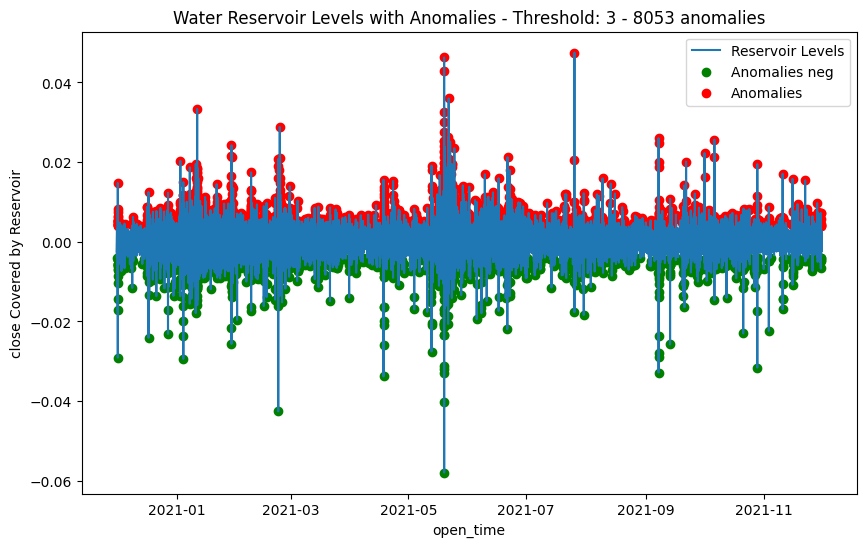

In [91]:
reservoir_data = df.copy()
reservoir_data['close'] = reservoir_data['close'].pct_change(periods=1)

def detect_anomalies(df, column_name, threshold=0.8):
    # Calculate mean and standard deviation
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    #df = df[df['close'] > 0]
    # Calculate Z-score for each data point
    df['Z_score'] = np.abs((df[column_name] - mean) / std_dev)

    # Flag data points with Z-score above threshold as anomalies
    anomalies = df[df['Z_score'] > threshold]

    return anomalies

# Assuming your DataFrame is named 'reservoir_data' and timestamp column is 'timestamp'
# Change 'close' to the appropriate column name representing the close covered by the reservoir
#reservoir_data = df.copy().reset_index().rename(columns={"index":"timestamp"})
threshold = 3
anomalies = detect_anomalies(reservoir_data, 'close',threshold )

# Displaying identified anomalies
print(anomalies)
#reservoir_data['timestamp'] = pd.to_datetime(reservoir_data['timestamp'])
# anomalies = detect_anomalies(reservoir_data, 'close')

# Plotting the reservoir levels and highlighting anomalies
plt.figure(figsize=(10, 6))
plt.plot(reservoir_data['open_time'], reservoir_data['close'], label='Reservoir Levels')
plt.scatter(anomalies[anomalies['close']<0]['open_time'], anomalies[anomalies['close']<0]['close'], color='green', label='Anomalies neg')
plt.scatter(anomalies[anomalies['close']>0]['open_time'], anomalies[anomalies['close']>0]['close'], color='red', label='Anomalies')

plt.xlabel('open_time')
plt.ylabel('close Covered by Reservoir')
plt.title(f'Water Reservoir Levels with Anomalies - Threshold: {threshold} - {int(len(anomalies))} anomalies')
plt.legend()
plt.show()